In [1]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# make sure the tables are here
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [6]:
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
# Get a list of column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine) 

## Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set. 
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

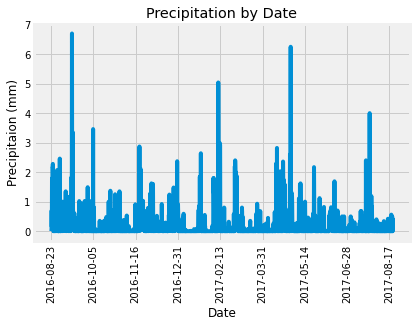

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
selection = [Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs]
measurement_data = session.query(*selection).filter(Measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df = pd.DataFrame(measurement_data)
measurement_df = measurement_df.rename(columns ={ 'prcp' : 'precipitation', 'tobs':'temperature'})
measurement_df = measurement_df.set_index('date').dropna()

# Sort the dataframe by date
measurement_df = measurement_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
precip_df = measurement_df['precipitation']
precip_df.plot(rot=90)
plt.title("Precipitation by Date")
plt.xlabel("Date")
plt.ylabel("Precipitaion (mm)")
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

## Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.id).count()

9

In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
selection =[Measurement.station, func.count(Measurement.station)]
session.query(*selection).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = session.query(*selection).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_active_station = most_active[0]

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()

[(54.0, 85.0, 71.66378066378067)]

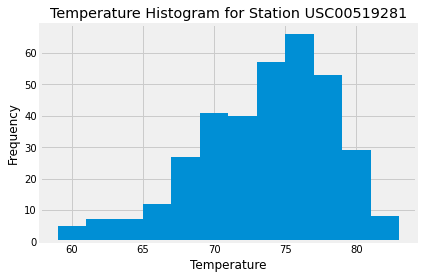

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
selection = [Measurement.date, Measurement.tobs]
active_data = session.query(*selection).filter(Measurement.date >= year_ago).filter(Measurement.station == most_active_station).all()
active_data_df = pd.DataFrame(active_data).set_index('date')
active_data_df.hist(bins=12)
plt.title(f"Temperature Histogram for Station {most_active_station}")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

In [17]:
# Close Session
session.close()